In [475]:
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore',category=Warning)

In [476]:
df = pd.read_csv(os.getcwd()+f'//..//..//data//processed//df_white_final.csv')

In [477]:
# Separando x e y

target = 'opinion'
x = df.drop(columns=[target])
y = df[[target]]

In [478]:
x

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3826,3937,5.7,0.21,0.32,0.9,0.038,38.0,121.0,0.99074,3.24,0.46,10.6
3827,3938,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
3828,3939,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
3829,3940,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [479]:
x.drop(columns='Unnamed: 0',inplace=True)

In [480]:
# Separando conjuntos de treino, validação e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train,random_state=10)

In [481]:
# Verificando as proporções de classes

proportions = pd.DataFrame(df[target].value_counts(normalize=True).values,
                     index=df[target].value_counts(normalize=True).index,
                     columns=['original'])
proportions['treino'] = y_train[target].value_counts(normalize=True).values
proportions['validação'] = y_val[target].value_counts(normalize=True).values
proportions['teste'] = y_test[target].value_counts(normalize=True).values
proportions

,original,treino,validação,teste
opinion,,,,
1,0.6651,0.665035,0.665579,0.664928
0,0.3349,0.334965,0.334421,0.335072


In [482]:
# Normalizando os dados

scaler = MinMaxScaler(feature_range=(0, 1))

# Treinando o scaler na base de treino

scaler.fit(x_train)

# Aplicando em todas as bases

x_train_norm = scaler.transform(x_train)
x_val_norm = scaler.transform(x_val)
x_test_norm = scaler.transform(x_test)

In [483]:
# Função para criar o modelo

def create_ann_model(x, n_neurons: list):
  """
  Cria a rede neural com base em parâmetros informados.
  """

  # Definir o modelo
  
  model = Sequential()
  if len(n_neurons) == 1:
    model.add(Dense(n_neurons[0], input_shape=(11,), activation='relu'))
  else:
    for n in n_neurons:
      if n == n_neurons[0]:
        model.add(Dense(n, input_shape=(11,), activation='relu'))
      else:
        model.add(Dense(n, activation='relu'))

  # Camada de saída - função de ativação sigmoidal
        
  model.add(Dense(1, activation='sigmoid'))

  return model


## Serão implementados 3 modelos variando a quantidade de neurônios somente na camada de entrada, a saída permenecerá com 1 neurônio.

```Modelo 1: 11 neurônios```

In [484]:
# Criando e testando o primeiro modelo

model_1 = create_ann_model(x_train_norm, n_neurons=[11])
model_1.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 11)                132       
                                                                 
 dense_73 (Dense)            (None, 1)                 12        
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 144 (576.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [485]:
# Função para calcular a f1-score

def f1_metric(y_train, y_val):
    y_val = tf.round(y_val)
    f1 = 2 * (tf.reduce_sum(y_train * y_val) + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_train) +
     tf.reduce_sum(y_val) + tf.keras.backend.epsilon())
    return f1


In [487]:
# Compilar o modelo com F1-score como métrica

model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=f1_metric)

In [488]:
# Treinando o primeiro modelo

history_1 = model_1.fit(x_train_norm, y_train, epochs=100, batch_size=60, validation_data=(x_val_norm, y_val))

Epoch 1/100


41/41 [==============================] - 1s 8ms/step - loss: 0.6959 - f1_metric: 0.4911 - val_loss: 0.6781 - val_f1_metric: 0.7278
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6642 - f1_metric: 0.7670 - val_loss: 0.6548 - val_f1_metric: 0.8086
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6460 - f1_metric: 0.7989 - val_loss: 0.6419 - val_f1_metric: 0.8098
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6356 - f1_metric: 0.7973 - val_loss: 0.6343 - val_f1_metric: 0.8098
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6294 - f1_metric: 0.7977 - val_loss: 0.6296 - val_f1_metric: 0.8090
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6255 - f1_metric: 0.7973 - val_loss: 0.6266 - val_f1_metric: 0.8090
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6228 - f1_metric: 0.7971 - val_loss: 0.6246 - val_f1_metric: 0.8090
Epoch 8/100

In [489]:
def plot_history(history, n_epochs):

    # Obtendo as métricas do histórico
    
    train_f1 = history.history['f1_metric']
    val_f1 = history.history['val_f1_metric']
    train_f1_loss = history.history['loss']
    val_f1_loss = history.history['val_loss']

    # Plotando o gráfico de F1-score

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(range(1,n_epochs+1), train_f1, label='Treino')
    plt.plot(range(1,n_epochs+1), val_f1, label='Validação')
    plt.legend(loc='best')
    plt.title('F1-score ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('F1-score')

     # Plotando o gráfico da função de perda
    
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, n_epochs+1), train_f1_loss, label='Treino')
    plt.plot(range(1, n_epochs+1), val_f1_loss, label='Validação')
    plt.legend(loc='best')
    plt.title('Função de perda ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Função de perda')
    plt.show()

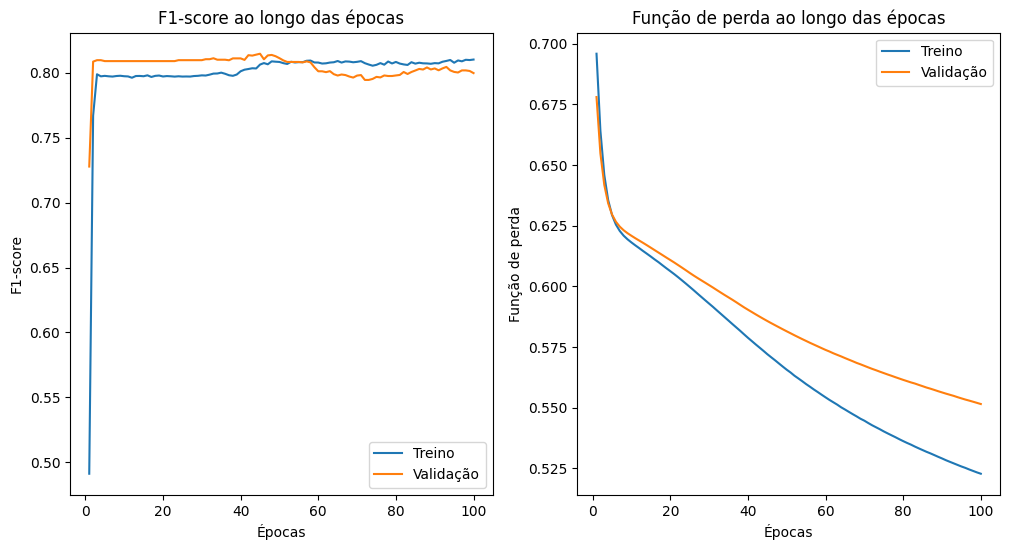

In [490]:
plot_history(history_1, 100)

```Modelo 2: 22 neurônios```

In [491]:
# Criando e testando o segundo modelo

model_2 = create_ann_model(x_train_norm, n_neurons=[22])
model_2.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 22)                264       
                                                                 
 dense_75 (Dense)            (None, 1)                 23        
                                                                 
Total params: 287 (1.12 KB)
Trainable params: 287 (1.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [492]:
# model_2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=f1_metric)

In [493]:
# Compilar o modelo com F1-score como métrica

model_2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=f1_metric)

In [494]:
# Treinando o segundo modelo

history_2 = model_2.fit(x_train_norm, y_train, epochs=100, batch_size=60, validation_data=(x_val_norm, y_val))

Epoch 1/100
41/41 [==============================] - 1s 8ms/step - loss: 0.6320 - f1_metric: 0.7969 - val_loss: 0.6295 - val_f1_metric: 0.8090
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6239 - f1_metric: 0.7971 - val_loss: 0.6245 - val_f1_metric: 0.8090
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6195 - f1_metric: 0.7963 - val_loss: 0.6214 - val_f1_metric: 0.8090
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6160 - f1_metric: 0.7971 - val_loss: 0.6189 - val_f1_metric: 0.8090
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6131 - f1_metric: 0.7977 - val_loss: 0.6168 - val_f1_metric: 0.8090
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6104 - f1_metric: 0.7973 - val_loss: 0.6150 - val_f1_metric: 0.8090
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6080 - f1_metric: 0.7972 - val_loss: 0.6132 - val_f1_metric: 0.8090

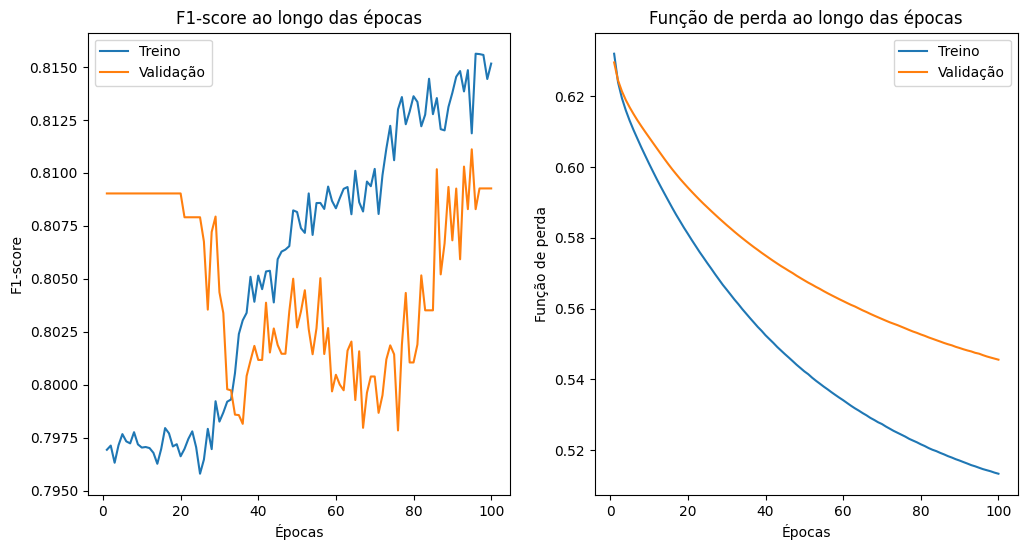

In [495]:
plot_history(history_2, 100)

```Modelo 3: 33 neurônios```

In [496]:
# Criando e testando o terceiro modelo

model_3 = create_ann_model(x_train_norm, n_neurons=[33])
model_3.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 33)                396       
                                                                 
 dense_77 (Dense)            (None, 1)                 34        
                                                                 
Total params: 430 (1.68 KB)
Trainable params: 430 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [497]:
# Compilando

# model_3.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=f1_metric)

In [498]:
# Compilar o modelo com F1-score como métrica

model_3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=f1_metric)

In [499]:
# Treinando o terceiro modelo

history_3 = model_3.fit(x_train_norm, y_train, epochs=100, batch_size=60, validation_data=(x_val_norm, y_val))

Epoch 1/100
41/41 [==============================] - 1s 8ms/step - loss: 0.6826 - f1_metric: 0.6712 - val_loss: 0.6640 - val_f1_metric: 0.7914
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6561 - f1_metric: 0.7971 - val_loss: 0.6461 - val_f1_metric: 0.8122
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6429 - f1_metric: 0.7976 - val_loss: 0.6371 - val_f1_metric: 0.8105
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6358 - f1_metric: 0.7976 - val_loss: 0.6319 - val_f1_metric: 0.8098
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6314 - f1_metric: 0.7980 - val_loss: 0.6285 - val_f1_metric: 0.8090
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6282 - f1_metric: 0.7976 - val_loss: 0.6261 - val_f1_metric: 0.8090
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6257 - f1_metric: 0.7975 - val_loss: 0.6242 - val_f1_metric: 0.8090

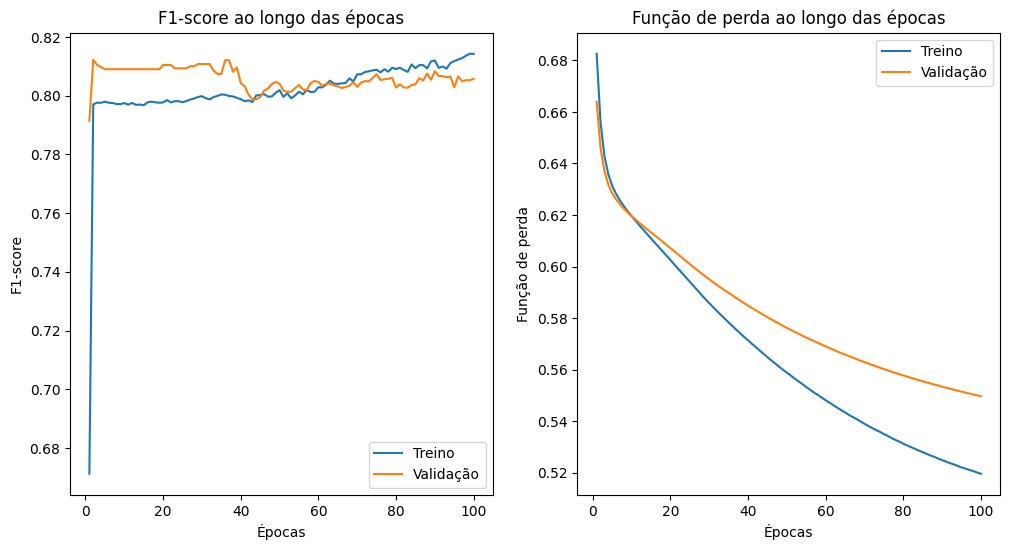

In [500]:
plot_history(history_3, 100)

In [501]:
# Função de análise de resultados

def analyze_results(x_test_norm, list_models, list_model_names, THRESHOLD=0.6):
  for i in range(len(list_models)):

    # Faz a previsão na base de teste

    yhat_test = list_models[i].predict(x_test_norm)

    # Transforma em classes

    yhat_test_class = [1 if x >= THRESHOLD else 0 for x in yhat_test]

    # Imprime resultados
    
    print(f'DESEMPENHO DE CLASSIFICAÇÃO - MODELO {i+1} - {list_model_names[i]} - Prob. min = {THRESHOLD}')
    print(classification_report(y_test, yhat_test_class))
   
    print('*' * 50)
    print('\n')

In [502]:
# Definindo lista de modelos e de nomes

list_models = [model_1, model_2, model_3]
list_model_names = ['11 neurônios', '22 neurônios', '33 neurônios']
analyze_results(x_test_norm, list_models, list_model_names)

24/24 [==============================] - 0s 2ms/step
DESEMPENHO DE CLASSIFICAÇÃO - MODELO 1 - 11 neurônios - Prob. min = 0.6
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       257
           1       0.82      0.82      0.82       510

    accuracy                           0.76       767
   macro avg       0.73      0.73      0.73       767
weighted avg       0.76      0.76      0.76       767

**************************************************


24/24 [==============================] - 0s 2ms/step
DESEMPENHO DE CLASSIFICAÇÃO - MODELO 2 - 22 neurônios - Prob. min = 0.6
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       257
           1       0.83      0.79      0.81       510

    accuracy                           0.76       767
   macro avg       0.73      0.74      0.73       767
weighted avg       0.76      0.76      0.76       767

*******************************************

In [527]:
y_pred = model_1.predict(x_test_norm)

y_class = [1 if x >= 0.6 else 0 for x in y_pred]

24/24 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Matriz de Confusão')

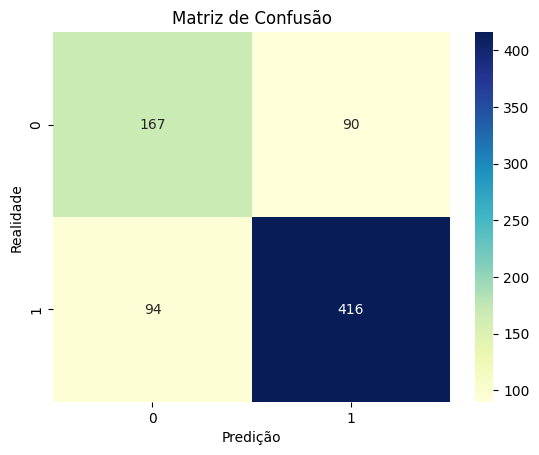

In [525]:
conf_matrix_red = confusion_matrix(y_test, y_class)

ax = sns.heatmap(conf_matrix_red, cmap='YlGnBu', annot=True, fmt='g')
ax.set_xlabel('Predição')
ax.set_ylabel('Realidade')
ax.set_title('Matriz de Confusão')

In [505]:
yhat_hist_train = model_1.predict(x_train_norm)

77/77 [==============================] - 1s 7ms/step


In [506]:
yhat_hist_test = model_1.predict(x_test_norm)

24/24 [==============================] - 0s 4ms/step


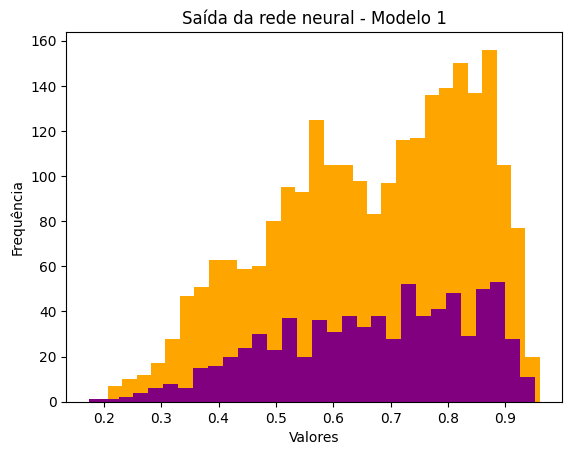

In [507]:
plt.title('Saída da rede neural - Modelo 1')
plt.hist(yhat_hist_train, bins=30, color='orange', label='treino')
plt.hist(yhat_hist_test, bins=30, color='purple', label='test')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()